In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import warnings

import gseapy as gp
from gseapy.plot import barplot, dotplot
import gffpandas.gffpandas as gffpd

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

path_to_data='/Users/aleksandradenisova/Desktop/coursework/data/'

In [141]:
order = pd.read_csv(f'{path_to_data}stage4/sorted_inno_sp.csv')
order = order.rename(columns = {'VGL ID':'sp2'})
order.head()

,TotInno_resResEff2022,sp2
0,1.974601,bHirRus1
1,1.950304,bAquChr1
2,1.565219,bCorMon1
3,1.445271,bEriRub2
4,1.357739,bSteHir1


In [145]:
table_names = ['two_alleles.tsv', 'fixed_inno.tsv', 'fixed_noninno.tsv']
cons_in_table = ['cons','inno','non_inno']

all_dfs = []
for i in range(3):
    df = pd.read_csv(f'{path_to_data}final_data/{table_names[i]}', sep = '\t')
    df['start'] = df['start']+1 
    df['type'] = cons_in_table[i]
    
    print(f'number of positions:  {df.shape[0]}')
    
    df3 = df[(((df['n_inno']==4)&(df['n_noninno']==4)) |
              (((df['n_inno']==3)&(df['n_noninno']==4))&((df['inno_N']==1)|(df['inno_-']==1)))|
             (((df['n_noninno']==3)&(df['n_inno']==4))&((df['noninno_N']==1)|(df['noninno_-']==1))))
              &(df[cons_in_table[i]]==True)]

    print(f'number of positions:  {df3.shape[0]}')
    
    all_dfs.append(df3)
    
df = pd.concat(all_dfs)

number of positions:  12271
number of positions:  2160
number of positions:  13637
number of positions:  2479
number of positions:  10663
number of positions:  1983


In [146]:
df.shape

(6622, 16)

In [14]:
df_chrom = pd.read_csv('~/Desktop/coursework/data/stage2/chroms_zebra.tsv', sep = '\t')[:-1]

df_chrom['Molecule name'] = df_chrom['Molecule name'].apply(lambda x: x.split()[1])
df1 = df_chrom[['RefSeq sequence', 'Molecule name']].rename(columns= {'RefSeq sequence':'chrom'})
df1.head()

,chrom,Molecule name
0,NC_044211.2,1
1,NC_044212.2,1A
2,NC_044213.2,2
3,NC_044214.2,3
4,NC_044215.2,4


In [65]:
df_p = df
    
df2 = pd.merge(df1,df_p, on='chrom').rename(columns = {
                                                    'chrom':'#CHROM', 'start':'POS', 
                                                    'Alt_noninno':'REF', 'Ref_inno':'ALT'})
df2['ID'] = '.'
df2['FILTER'] = '.'
df2['INFO'] = '.'
df2['POS'] = df2['POS']+1

df3 = df2[['#CHROM', 'POS','ID',  'REF','ALT', 'FILTER', 'INFO', 'type']]

df3.to_csv(f'{path_to_data}/final_data/positions_for_8.vcf', 
            index = False,
            sep = '\t')

In [74]:
f'{path_to_data}/final_data/positions_for_8.vcf'

'/Users/aleksandradenisova/Desktop/coursework/data//final_data/positions_for_8.vcf'

### Launched from /Users/aleksandradenisova/Desktop/coursework/code/scripts/scripts


sh bash_snpEff.sh final_data positions_for_8.vcf 2> ~/Desktop/coursework/data/final_data/zibra.log

### Cобираем мутации из полученных файлов

In [98]:
df_ann = pd.read_csv(f'{path_to_data}/final_data/positions_for_8.vcf.ann', 
                     skiprows=6, 
                     sep = '\t', 
                     names = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'FILTER', 'smth','INFO'],
)
df_ann['type_of_pos'] = df_ann['INFO'].apply(lambda x: x.split(';')[0])
df_ann['INFO'] = df_ann['INFO'].apply(lambda x: x.split(';')[1])

In [99]:
ans = []
for idx in df_ann.index:
    new_info =  df_ann['INFO'].iloc[idx].split('|,')

    for inf in new_info:
        tt = df_ann.iloc[idx]
        tt['info'] = inf
        ans.append(tt)

df_new = pd.DataFrame(ans).drop(columns = 'INFO').reset_index(drop=True)
df_new['type'] = df_new['info'].apply(lambda x: x.split('|')[1])
df_new['gene_name'] = df_new['info'].apply(lambda x: x.split('|')[3])
df_new['effect'] = df_new['info'].apply(lambda x: x.split('|')[2])

In [100]:
df_new.head()

,#CHROM,POS,ID,REF,ALT,FILTER,smth,type_of_pos,info,type,gene_name,effect
0,NC_044211.2,407366,.,G,A,.,.,cons,ANN=A|intron_variant|MODIFIER|TMEM45A|TMEM45A|...,intron_variant,TMEM45A,MODIFIER
1,NC_044211.2,407366,.,G,A,.,.,cons,A|intron_variant|MODIFIER|TMEM45A|TMEM45A|tran...,intron_variant,TMEM45A,MODIFIER
2,NC_044211.2,1305680,.,T,C,.,.,cons,ANN=C|intergenic_region|MODIFIER|LOC121470433-...,intergenic_region,LOC121470433-ALCAM,MODIFIER
3,NC_044211.2,1481306,.,T,C,.,.,cons,ANN=C|intergenic_region|MODIFIER|LOC121470433-...,intergenic_region,LOC121470433-ALCAM,MODIFIER
4,NC_044211.2,1837255,.,G,A,.,.,cons,ANN=A|intron_variant|MODIFIER|ALCAM|ALCAM|tran...,intron_variant,ALCAM,MODIFIER


#### Итого отобрано генов:

In [101]:
df_genes = pd.read_csv(f'{path_to_data}/final_data/positions_for_8.vcf.txt', 
            sep = '\t', 
            skiprows=1, 
)
df_genes.head()

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,...,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_acceptor_variant,variants_effect_splice_donor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
0,A2M,A2M,XM_030268194.3,protein_coding,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AADAT,AADAT,XM_041715834.1,protein_coding,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,AAR2,AAR2,XM_030288651.3,protein_coding,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,AASDH,AASDH,XM_012573522.4,protein_coding,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AASDH,AASDH,XM_030271137.3,protein_coding,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
unique_genes_big = df_genes['GeneId'].unique()
df_new = df_new[df_new['gene_name'].apply(lambda x: x in unique_genes_big)]
df_new[['type_of_pos', 'gene_name']].drop_duplicates()['type_of_pos'].value_counts()

inno        1712
cons        1619
non_inno    1427
Name: type_of_pos, dtype: int64

In [147]:
len(unique_genes_big)

3977

In [119]:
go_BP = gp.get_library(name='GO_Biological_Process_2021', organism='Human')

def get_df(database, genelist, background):
    enr = gp.enrichr(gene_list=genelist ,
        gene_sets=database,
        background = background,  
        outdir=None,
        cutoff=0.5,                          
     )
    return enr

def plot(df, bg, name):
    name = ' '.join(name.split('_'))
    barplot(df.res2d,title= name+bg, top_term=15, cutoff=0.05,color = 'r')
    plt.plot([l,l],[-1, 15], linestyle = '--',color='k', label = '- log10(0.05)')

In [123]:
annotation = gffpd.read_gff3('{}stage2/{}'.format(path_to_data, 'GCF_003957565.2_bTaeGut1.4.pri_genomic.gff'))

df_ori = annotation.df
df_ori['chrom']=df_ori['seq_id']
df = df_ori[df_ori['type']=='gene']

df['element_ID'] = df['attributes'].apply(lambda x: x.split(';')[0].split('=')[1].split('-')[1])
background = df['element_ID'].tolist()

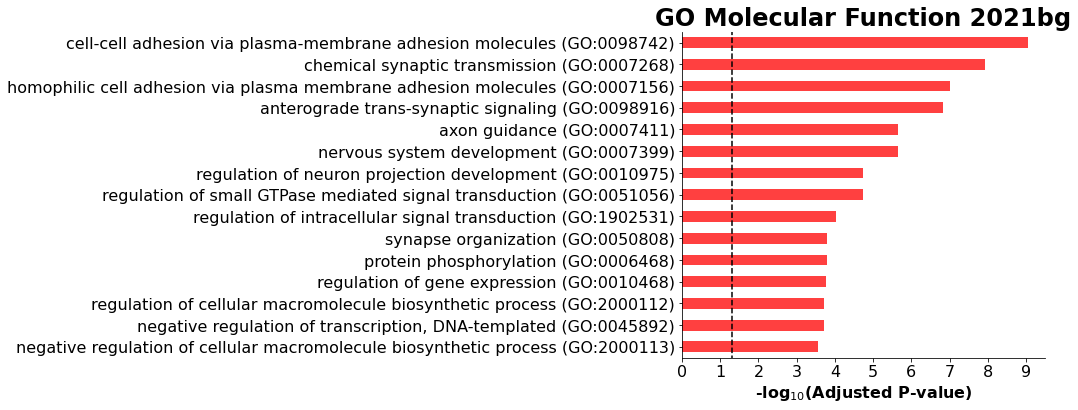

In [127]:
l = -np.log10(0.05)
plot(get_df(go_BP, list(unique_genes_big), background), 'bg', 'GO_Molecular_Function_2021')

Распределение по транскриптам:


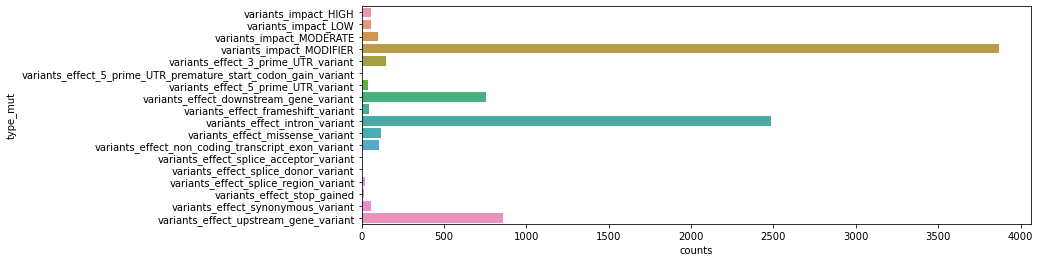

,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,variants_effect_5_prime_UTR_variant,variants_effect_downstream_gene_variant,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_acceptor_variant,variants_effect_splice_donor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
counts,57,60,97,3871,151,4,37,758,45,2484,120,106,1,1,21,14,57,856
type_mut,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_co...,variants_effect_5_prime_UTR_variant,variants_effect_downstream_gene_variant,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_var...,variants_effect_splice_acceptor_variant,variants_effect_splice_donor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant


In [135]:
print('Распределение по транскриптам:')

df_counts_types = pd.DataFrame((df_genes.groupby("GeneId").sum()!=0).sum(), columns = ['counts'])
df_counts_types['type_mut'] = df_counts_types.index

plt.figure(figsize = (12,4))
sns.barplot(data = df_counts_types, x = 'counts', y = 'type_mut')
plt.show()
df_counts_types.T

In [128]:
df_genes_miss = df_genes[df_genes['variants_effect_missense_variant']>=1]
unique_genes = df_genes_miss['GeneId'].unique()
len(unique_genes)

120

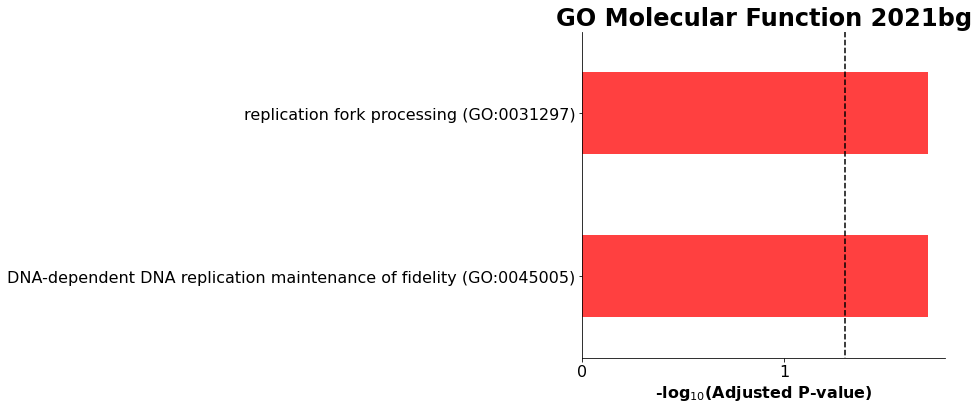

In [131]:
plot(get_df(go_BP, list(unique_genes), background), 'bg', 'GO_Molecular_Function_2021')

In [129]:
df_genes_miss

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,...,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_acceptor_variant,variants_effect_splice_donor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
145,ACTL10,ACTL10,XM_030288865.3,protein_coding,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
191,ADCY9,ADCY9,XM_002194859.6,protein_coding,1,0,0,2,0,0,...,1,2,1,0,0,0,0,0,0,0
192,ADCY9,ADCY9,XM_030285269.3,protein_coding,1,0,0,2,0,0,...,1,2,1,0,0,0,0,0,0,0
333,AGBL1,AGBL1,XM_030281428.3,protein_coding,0,1,1,1,0,0,...,0,1,1,0,0,0,0,0,1,0
334,AGBL1,AGBL1,XM_030281429.3,protein_coding,0,1,1,1,0,0,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12625,ZNF507,ZNF507,XM_030282173.3,protein_coding,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
12626,ZNF507,ZNF507,XM_030282174.3,protein_coding,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
12627,ZNF507,ZNF507,XM_030282176.3,protein_coding,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
12628,ZNF507,ZNF507,XM_030282177.3,protein_coding,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [111]:
df_new_miss = df_new[df_new['gene_name'].apply(lambda x: x in unique_genes)]
df_new_miss[['type_of_pos', 'gene_name']].drop_duplicates()['type_of_pos'].value_counts()

cons        85
inno        42
non_inno    36
Name: type_of_pos, dtype: int64

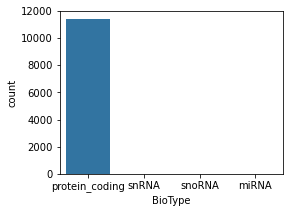

Counts:


protein_coding    11449
miRNA                19
snoRNA               11
snRNA                 4
Name: BioType, dtype: int64

In [45]:
plt.figure(figsize = (4,3))
sns.countplot(data=df_genes, x="BioType")
plt.show()

print("Counts:")
df_genes['BioType'].value_counts()

In [46]:
df_genes[df_genes['BioType']=='snoRNA']

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,...,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_acceptor_variant,variants_effect_splice_donor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
6356,LOC115495693,LOC115495693,XR_003960995.1,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6361,LOC115495888,LOC115495888,XR_003961213.3,snoRNA,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
6441,LOC115496473,LOC115496473,XR_003961976.1,snoRNA,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,2
6442,LOC115496475,LOC115496475,XR_003961978.1,snoRNA,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,2
6443,LOC115496477,LOC115496477,XR_003961980.1,snoRNA,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,2
6579,LOC115497774,LOC115497774,XR_003963361.3,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6580,LOC115497777,LOC115497777,XR_003963364.3,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6584,LOC115497831,LOC115497831,XR_003963408.3,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6585,LOC115497843,LOC115497843,XR_003963420.3,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6586,LOC115497844,LOC115497844,XR_003963421.3,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
df_genes[df_genes['variants_effect_missense_variant']>0]

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,...,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_acceptor_variant,variants_effect_splice_donor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
145,ACTL10,ACTL10,XM_030288865.3,protein_coding,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
191,ADCY9,ADCY9,XM_002194859.6,protein_coding,1,0,0,2,0,0,...,1,2,1,0,0,0,0,0,0,0
192,ADCY9,ADCY9,XM_030285269.3,protein_coding,1,0,0,2,0,0,...,1,2,1,0,0,0,0,0,0,0
333,AGBL1,AGBL1,XM_030281428.3,protein_coding,0,1,1,1,0,0,...,0,1,1,0,0,0,0,0,1,0
334,AGBL1,AGBL1,XM_030281429.3,protein_coding,0,1,1,1,0,0,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12625,ZNF507,ZNF507,XM_030282173.3,protein_coding,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
12626,ZNF507,ZNF507,XM_030282174.3,protein_coding,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
12627,ZNF507,ZNF507,XM_030282176.3,protein_coding,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
12628,ZNF507,ZNF507,XM_030282177.3,protein_coding,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [49]:
[i for i in df_genes['GeneId'].unique() if i.startswith('TRNAP')]

['TRNAP-AGG_1', 'TRNAP-CGG']

In [50]:
df_genes[df_genes['GeneId']=='TRNAP-CGG']

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,...,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_acceptor_variant,variants_effect_splice_donor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
11900,TRNAP-CGG,TRNAP-CGG,unassigned_transcript_14,protein_coding,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
